In [1]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import measure
from scipy.ndimage import gaussian_filter
from scipy.stats import mode
from scipy import signal
import cv2
import skimage
from skimage.morphology import erosion, disk, dilation
import imutils
import numpy.ma as ma
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import sklearn.cluster
import sklearn.linear_model
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [2]:
images = os.listdir("training")
images.remove('test')
images.remove('.DS_Store')
images = sorted(images)

In [4]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.morphology import erosion, disk, dilation
import imutils
import numpy.ma as ma
import os
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster
from sklearn.decomposition import KernelPCA



def get_features(image):
    res = image.copy()
    hist0 = cv2.calcHist([res],[0], None, [64],[0,256])[19:47]
    hist1 = cv2.calcHist([res],[1], None, [64],[0,256])[19:47]
    hist2 = cv2.calcHist([res],[2], None, [64],[0,256])[19:47]

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    modific = [gray, skimage.morphology.erosion(gray, skimage.morphology.disk(1))]
    for index in range(len(modific)):
        g_im = modific[index]

        g_im = cv2.GaussianBlur(g_im, (3, 3) , cv2.BORDER_DEFAULT)


        th = skimage.filters.threshold_li(g_im)
        ret = np.zeros((image.shape[0], image.shape[1]), np.uint8)
        ret[g_im>=th]+=1
        ret[ret > 0] = 255

        bnk = np.zeros(image.shape, dtype=np.uint8)
        contour = cv2.findContours(ret, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        dst = cv2.distanceTransform(ret, distanceType=cv2.DIST_L2, maskSize=5) 
        cv2.normalize(dst, dst, 0, 1.0, cv2.NORM_MINMAX);
        yc, xc = np.argmax(dst)//dst.shape[1], np.argmax(dst)%dst.shape[1]
        cnts = imutils.grab_contours(contour)
        max_cont = None
        max_len = 0
        for c in cnts:
            if len(c) > max_len:
                max_len = len(c)
                max_cont = c

        c = max_cont


        M = cv2.moments(c)
        M = cv2.moments(ret, 1)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        i = 0
        dist = np.zeros(c.shape[0])



        for element in c:
            x, y = element[0][0], element[0][1]  
            dist[i] = (x-cX)**2 + (y-cY)**2
            i += 1

        k = 30
        left_loc_min = np.zeros(c.shape[0])
        right_loc_min = np.zeros(c.shape[0])
        loc_min = np.zeros(c.shape[0])
        for j in range(k, len(dist) - k):
            if min(dist[j + 1:j + k + 1]) >= dist[j]:
                right_loc_min[j] = 1
            if min(dist[j - k:j]) >= dist[j]:
                left_loc_min[j] = 1
            if left_loc_min[j] and right_loc_min[j]:
                if j > 4.8 * k and np.sum(loc_min[int(j-4.8*k):j]) != 0 :
                    continue
                loc_min[j] = 1


        ind_min = ma.nonzero(loc_min)[0]
        ind_max = np.zeros(len(ind_min), dtype='int64')
        acos_min = np.zeros(len(ind_min))
        acos_max = np.zeros(len(ind_min))


        for j in range(len(ind_min)):
            d = 0

            d_max = dist[ind_min[j]]
            ind_max[j] = ind_min[j]
            a, b = ind_min[j], ind_min[(j+1)%len(ind_min)]
            if a > b:
                b += len(dist)
            for p in range(a, b):
                ind = p % len(dist)
                if dist[ind] > d_max:
                    d_max = dist[ind]
                    ind_max[j] = ind
            x1, y1 = c[a][0]
            x2, y2 = c[ind_max[j]][0]
            x3, y3 = c[b % len(dist)][0]
            acos_max[j] = ((x1-x2)*(x3-x2)+(y1-y2)*(y3-y2))/(((x1-x2)**2 + (y1-y2)**2)*((x3-x2)**2 + (y3-y2)**2))**0.5

        for j in range(len(ind_min)):
            x1, y1 = c[ind_max[j-1]][0]
            x2, y2 = c[ind_min[j]][0]
            x3, y3 = c[ind_max[j]][0]
            acos_min[j] = ((x1-x2)*(x3-x2)+(y1-y2)*(y3-y2))/(((x1-x2)**2 + (y1-y2)**2)*((x3-x2)**2 + (y3-y2)**2))**0.5
        acos_min = np.arccos(acos_min)
        acos_max = np.arccos(acos_max)
        start = 0
        for m in range(len(ind_min)):
            if acos_min[m] < 9/16 * np.pi or acos_min[m-5] < 9/16 * np.pi:
                continue
            if (acos_min[m-1] > 2/3 * np.pi or acos_min[m-2] > 2/3 * np.pi or acos_min[m-3] > 2/3 * np.pi or \
                acos_min[m-4] > 2/3 * np.pi):
                continue
            start = m

            x_c, y_c = c[ind_min[m]][0]
            x_e, y_e = c[ind_min[m-5]][0]
            cv2.line(bnk, (x_c, y_c), (x_e, y_e), (88,255,30), 2)

        big_finger = start - 4
        max_dst = 0
        min_dst = 10000
        array_len = np.zeros(8)
        count = 0
        dist_center = np.zeros(9)

        for t in range(start - 4, start):

            a1, b1 = c[ind_max[t-1]][0]
            a2, b2 =  c[ind_max[t]][0]
            a, b = c[ind_min[t]][0]

            max_d = ((a1 - a)**2 + (b1 - b)**2)**0.5 + ((a2 - a)**2 + (b2 - b)**2)**0.5

            left, right = ind_max[t-1], ind_max[t]
            if left > right:
                right += len(c)
            for dot in range(left, right):
                j = dot % len(c)
                x, y = c[j][0]
                d = ((a1 - x)**2 + (b1 - y)**2)**0.5 + ((a2 - x)**2 + (b2 - y)**2)**0.5
                if d > max_d:
                    ind_min[t] = j
                    max_d = d


            a, b = c[ind_min[t]][0]  
            if ((a1 - a)**2 + (b1 - b)**2)**0.5 < min_dst and ((a2 - a)**2 + (b2 - b)**2)**0.5 > max_dst:
                big_finger = t
                min_dst = ((a1 - a)**2 + (b1 - b)**2)**0.5
                max_dst = ((a2 - a)**2 + (b2 - b)**2)**0.5

            array_len[count] = ((a1 - a)**2 + (b1 - b)**2)**0.5
            array_len[count + 1] = ((a2 - a)**2 + (b2 - b)**2)**0.5
            dist_center[count] = ((xc - a)**2 + (yc - b)**2)**0.5
            dist_center[count + 1] = ((a1 - xc)**2 + (b1 - yc)**2)**0.5
            count += 2
            
        ae, be = c[ind_max[start-1]][0]  
        dist_center[-1] = ((ae - xc)**2 + (be - yc)**2)**0.5

        if big_finger == start - 1:
            array_len = array_len[::-1]
            dist_center = dist_center[::-1]

        bad = False
        for t in range(3, 8):
            if array_len[t]/array_len[t-1] > 2:
                bad = True
                break
                
        if bad and index != len(modific) - 1:
            continue
        min_dst = 100000
        min_dst_idx = 0
        max_dst = 0
        max_dst = 0

        for j in range(start-4, start):

            x1, y1 = c[ind_max[j]][0]
            x2, y2 = c[ind_min[j]][0]
            x3, y3 = c[ind_max[j-1]][0]
            
            if min_dst > ((x2 - xc)**2 + (y2 - yc)**2)**0.5:
                min_dst = ((x2 - xc)**2 + (y2 - yc)**2)**0.5
                min_dst_idx = ind_min[j]
                
            if max_dst < ((x1 - xc)**2 + (y1 - yc)**2)**0.5:
                max_dst = ((x1 - xc)**2 + (y1 - yc)**2)**0.5
                max_dst_idx = ind_max[j]
                
            if max_dst < ((x3 - xc)**2 + (y3 - yc)**2)**0.5:
                max_dst = ((x3 - xc)**2 + (y3 - yc)**2)**0.5
                max_dst_idx = ind_max[j-1]
                

        thick = np.zeros(3, dtype=np.float64)    
        for i, j in enumerate(range(start-3, start)):
            x1, y1 = c[ind_min[j-1]][0]
            x2, y2 = c[ind_min[j]][0]
            thick[i] = ((x1 - x2)**2 + (y1 - y2)**2)**0.5

        if big_finger == start - 1:
            thick = thick[::-1]     

        angles = np.zeros(5, dtype=np.float64)
        for i, ind in enumerate(range(start-4, start-1)):
            angles[i] = acos_max[ind]
        if big_finger == start - 1:
            angles = angles[::-1] 
        
        ang_cos = ((1 + np.cos(angles))/2)**0.5
        array_len_diag = array_len.copy()
        if big_finger == start - 1:
            array_len_diag[0] *= ((1 + np.cos(acos_min[start-4]))/2)**0.5
            array_len_diag[7] *= ((1 + np.cos(acos_min[start-1]))/2)**0.5
        else:
            array_len_diag[0] *= ((1 + np.cos(acos_min[start-1]))/2)**0.5
            array_len_diag[7] *= ((1 + np.cos(acos_min[start-4]))/2)**0.5
        for ang in range(3):
            array_len_diag[2 * ang + 2] *= ang_cos[ang]
            array_len_diag[2 * ang + 1] *= ang_cos[ang]
            
        max_x, max_y = c[max_dst_idx][0]
        if max_y > yc:
            angle = 180 - np.arcsin((max_x - xc) /((max_x - xc)**2 + (max_y - yc)**2)**0.5) * 180 / np.pi
        else:
            angle = np.arcsin((max_x - xc) /((max_x - xc)**2 + (max_y - yc)**2)**0.5) * 180 / np.pi

        image_center = (xc, yc)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        circ = cv2.warpAffine(res, rot_mat, bnk.shape[1::-1], flags=cv2.INTER_LINEAR)
        min_dst = 100
        height = max_dst + yc
        if yc+min_dst > res.shape[0]:
            yc = res.shape[0] - min_dst
        result = circ[yc-int(min_dst):yc+int(min_dst), xc-int(min_dst):xc+int(min_dst), :]

        result = skimage.exposure.adjust_sigmoid(result)
        gray_mask = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
        gray_mask = skimage.exposure.adjust_sigmoid(gray_mask)
        features = {'fingers_len': array_len, 'fingers_len_diag': array_len_diag, 'fingers_thick': thick,\
                    'fingers_angles': angles, 'lines': gray_mask.ravel(),
                    'square': M["m00"], 'perimeter': len(max_cont), 'hist': [hist0, hist1, hist2],
                    'mean_len': np.mean(array_len), 'dist': dist_center}

        return features
    
def get_feature_vector(image):
    vec = np.zeros(41000, dtype=np.float64)
    features = get_features(image)
    i = 0

    for elem in features['fingers_len']:
        for elem1 in features['fingers_len']:#8 0-7
            if elem != elem1:
                vec[i] = elem/elem1
                i += 1
    for elem in features['fingers_len_diag']: #8 8-15
        vec[i] = elem
        i += 1
    for elem in features['dist']: #9 16-24
        vec[i] = elem
        i += 1
    for elem in features['fingers_thick']: #3 25-27
        vec[i] = elem
        i += 1
    vec[i] = features['square'] #28
    vec[i + 1] = features['perimeter'] #29
    vec[i + 2] = features['mean_len'] #30
    i += 3
    for elem in features['fingers_angles']: #5 31-35
        vec[i] = elem
        i += 1


    for hist in features['hist']:
        for elem in hist:
            vec[i] = elem
            i += 1
   
    for elem in features['lines']: 
        vec[i] = elem
        i += 1

    return vec    


#images = os.listdir("input")
#images = sorted(images)

X = np.zeros((len(images), 41000), dtype=np.float64)
for i, image_name in enumerate(images):
    image = plt.imread(f'training/{image_name}')
    X[i] = get_feature_vector(image)
    
newX = X
n_c = 50
pca = KernelPCA(n_components=n_c, kernel='poly', degree=5)
newX[:, 168: 168+n_c] = pca.fit_transform(newX[:, 168:])
newX = newX[:,: 168+n_c]

scaler = StandardScaler()
newX = scaler.fit_transform(newX)

newX = np.where(np.isnan(newX), 0, newX)
newX = np.where(np.isinf(newX), 1e5, newX)
clustering = sklearn.cluster.AffinityPropagation(max_iter=200, convergence_iter=15,
                                                 affinity='euclidean').fit(newX)
f_clusters = open('clusters.txt', 'w')
f_clusters.write(f'Число персон: {max(clustering.labels_) + 1}\n')
for i in range(max(clustering.labels_) + 1):
    f_clusters.write(f'Персона №: {i}\n')
    for idx in np.where(clustering.labels_ == i)[0]:
        f_clusters.write(f'{images[idx]} ')
    f_clusters.write('\n')
f_clusters.close()

    
    
nbrs = NearestNeighbors(n_neighbors=4, algorithm='brute', metric='euclidean').fit(newX)
distances,  indices =  nbrs.kneighbors(newX)
f_neighbours = open('neighbors.txt', 'w')
    
for arr in indices:
    f_neighbours.write(f'object:{images[arr[0]]} neighbors:{images[arr[1]]} {images[arr[2]]} {images[arr[3]]}\n')
f_neighbours.close()

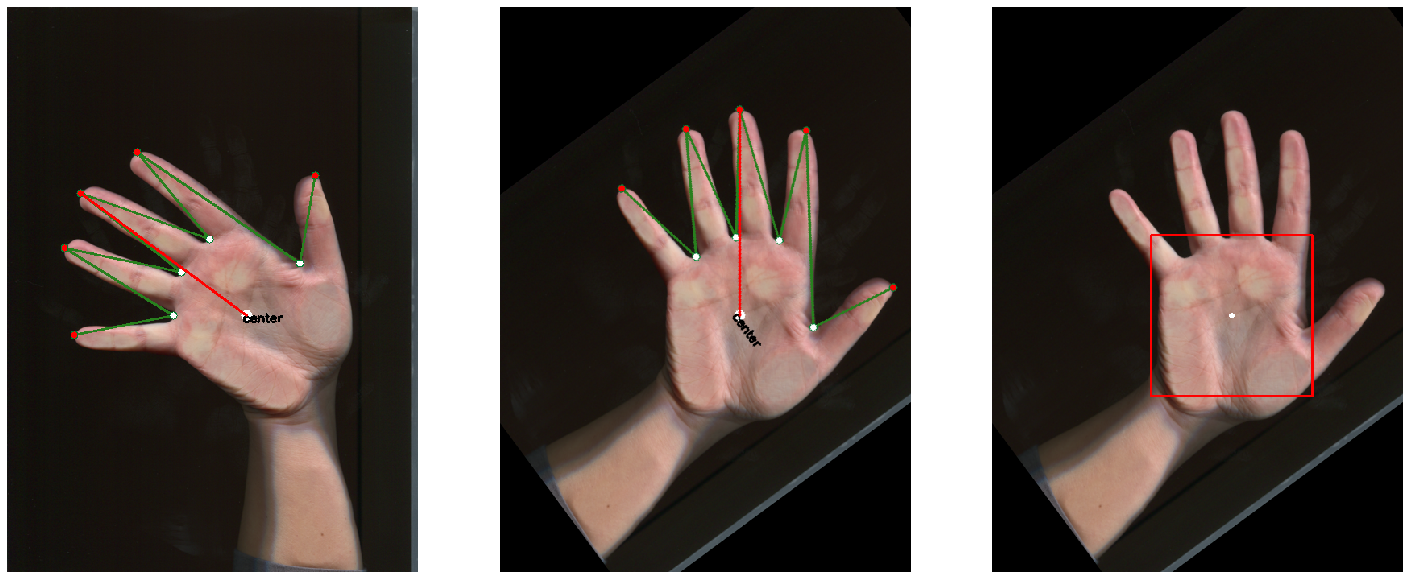

In [1073]:

fig, axes = plt.subplots(1, 3, figsize=(25, 15))
image = plt.imread(f'training/049.tif')
meow = alg(image)
axes[0].imshow(meow[0], cmap='gray')
axes[0].axis('off')

axes[1].imshow(meow[1], cmap='gray')
axes[1].axis('off')


axes[2].imshow(alg(image)[2], cmap='gray')
axes[2].axis('off');
fig.savefig('3.png')

In [10]:
clustering = sklearn.cluster.AffinityPropagation(max_iter=200, convergence_iter=15,
                                                 affinity='euclidean').fit(newX)
print(max(clustering.labels_) + 1)
for i in range(max(clustering.labels_) + 1):
    print('Персона №', i)
    for idx in np.where(clustering.labels_ == i)[0]:
        print(images[idx], end=' ')
    print()


13
Персона № 0
001.tif 002.tif 
Персона № 1
003.tif 004.tif 
Персона № 2
005.tif 006.tif 007.tif 008.tif 009.tif 010.tif 011.tif 065.tif 097.tif 123.tif 138.tif 141.tif 
Персона № 3
012.tif 013.tif 014.tif 015.tif 
Персона № 4
016.tif 017.tif 018.tif 019.tif 020.tif 021.tif 022.tif 023.tif 031.tif 034.tif 047.tif 082.tif 122.tif 124.tif 
Персона № 5
026.tif 027.tif 028.tif 029.tif 036.tif 
Персона № 6
035.tif 046.tif 051.tif 052.tif 053.tif 054.tif 055.tif 056.tif 068.tif 095.tif 099.tif 
Персона № 7
064.tif 066.tif 076.tif 077.tif 078.tif 079.tif 081.tif 092.tif 093.tif 118.tif 120.tif 
Персона № 8
024.tif 049.tif 086.tif 088.tif 091.tif 
Персона № 9
106.tif 
Персона № 10
037.tif 039.tif 041.tif 050.tif 057.tif 060.tif 071.tif 090.tif 142.tif 144.tif 145.tif 146.tif 
Персона № 11
150.tif 151.tif 152.tif 
Персона № 12
063.tif 067.tif 096.tif 105.tif 107.tif 109.tif 111.tif 112.tif 113.tif 114.tif 126.tif 127.tif 128.tif 129.tif 135.tif 155.tif 157.tif 


In [7]:
from sklearn.metrics.pairwise import rbf_kernel

def dst(x, y):
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)
    gamma = 1/(1000000 * x.shape[1])
    return rbf_kernel(x, x, gamma=gamma) + rbf_kernel(y, y, gamma=gamma) - 2 * rbf_kernel(x, y, gamma=gamma)
    
    
nbrs = NearestNeighbors(n_neighbors=4, algorithm='brute', metric='euclidean').fit(newX)
distances,  indices =  nbrs.kneighbors(newX)
for arr in indices:
    print(f'object:{images[arr[0]]} neighbors:{images[arr[1]]} {images[arr[2]]} {images[arr[3]]}')

object:001.tif neighbors:002.tif 003.tif 004.tif
object:002.tif neighbors:001.tif 003.tif 004.tif
object:003.tif neighbors:004.tif 001.tif 002.tif
object:004.tif neighbors:003.tif 001.tif 002.tif
object:005.tif neighbors:006.tif 007.tif 009.tif
object:006.tif neighbors:005.tif 009.tif 007.tif
object:007.tif neighbors:005.tif 006.tif 010.tif
object:008.tif neighbors:011.tif 006.tif 009.tif
object:009.tif neighbors:011.tif 006.tif 010.tif
object:010.tif neighbors:011.tif 009.tif 005.tif
object:011.tif neighbors:009.tif 010.tif 006.tif
object:012.tif neighbors:014.tif 013.tif 015.tif
object:013.tif neighbors:014.tif 015.tif 012.tif
object:014.tif neighbors:013.tif 015.tif 012.tif
object:015.tif neighbors:013.tif 014.tif 012.tif
object:016.tif neighbors:017.tif 018.tif 020.tif
object:017.tif neighbors:018.tif 020.tif 021.tif
object:018.tif neighbors:021.tif 019.tif 017.tif
object:019.tif neighbors:021.tif 018.tif 017.tif
object:020.tif neighbors:017.tif 018.tif 016.tif
object:021.tif neigh

In [1257]:
clustering = sklearn.cluster.AffinityPropagation(max_iter=200, convergence_iter=15,
                                                 affinity='euclidean').fit(newX)
f_clusters = open('clusters.txt', 'w')
f_clusters.write(f'Число персон: {max(clustering.labels_) + 1}\n')
for i in range(max(clustering.labels_) + 1):
    f_clusters.write(f'Персона №: {i}\n')
    for idx in np.where(clustering.labels_ == i)[0]:
        f_clusters.write(f'{images[idx]} ')
    f_clusters.write('\n')
f_clusters.close()

    
    
nbrs = NearestNeighbors(n_neighbors=4, algorithm='brute', metric='euclidean').fit(newX)
distances,  indices =  nbrs.kneighbors(newX)
f_neighbours = open('neighbors.txt', 'w')
    
for arr in indices:
    f_neighbours.write(f'object:{images[arr[0]]} neighbors:{images[arr[1]]} {images[arr[2]]} {images[arr[3]]}\n')
f_neighbours.close()

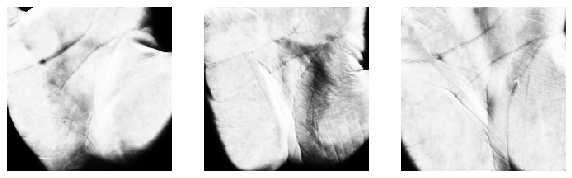

In [945]:

fig, axes = plt.subplots(1, 3, figsize=(10, 8))
image = plt.imread(f'training/006.tif')
meow = alg(image)
axes[0].imshow(meow[1], cmap='gray')
axes[0].axis('off')

image = plt.imread(f'training/157.tif')
meow1 = alg(image)
axes[1].imshow(meow1[1], cmap='gray')
axes[1].axis('off')

image = plt.imread(f'training/096.tif')
meow2 = alg(image)
axes[2].imshow(alg(image)[1], cmap='gray')
axes[2].axis('off');


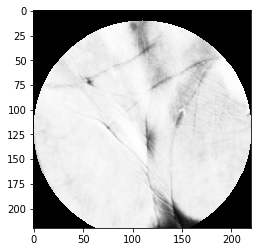

In [921]:
gray = cv2.cvtColor(meow2[1], cv2.COLOR_RGB2GRAY)
for i in range(2):
    gray = skimage.exposure.adjust_sigmoid(gray)

th = skimage.filters.threshold_li(gray)
ret = np.zeros(gray.shape, np.uint8)
ret[gray>=th]+=1
ret[ret > 0] = 255

plt.imshow(gray, cmap='gray')

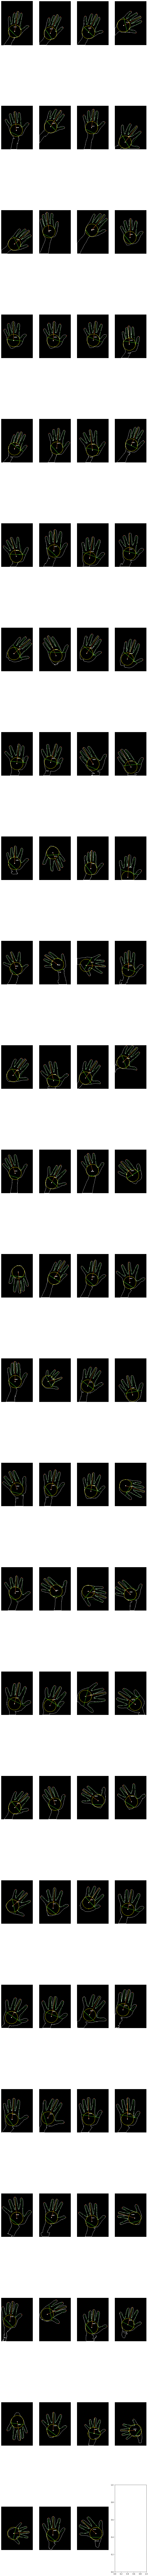

In [477]:
row = 25
col = 4
fig, axes = plt.subplots(row, col, figsize=(15, 275))
ln = np.zeros(99)
for j in range(0, 99):
    filename = images[j]

    image = cv2.imread(f'training/{filename}')
    ln[j], res = alg(image)
    res1 = res.copy()
    #res1[:, :, 2] = res[:, :, 0]
    #res1[:, :, 0] = res[:, :, 2]
    axes[j//col][j % col].imshow(res1, cmap='gray')
    axes[j//col][j % col].axis('off')